# Data Acquisition

In [1]:
import os
import shutil

import pandas as pd
import numpy as np

import matplotlib.pylab as plt
import seaborn as sns

import librosa
import librosa.display

# !sudo apt-get install p7zip-full

## Definition of Control Variables

In [2]:
GDRIVE_DATA_DIR = "23-24_CE903-SU_team06/dataset/"
from google.colab import drive
contentPath = "/content/"
if not os.path.exists(contentPath + 'drive'):
  drive.mount( contentPath + 'drive')
csv_files = [f"/content/drive/My Drive/{GDRIVE_DATA_DIR}audio_data_12_before_framing_16Khz.feather"]
df_from_save = pd.read_feather(csv_files[0])
df_from_save['key'] = df_from_save['index']
df_from_save.drop(columns=['index'], inplace=True)
df_from_save.set_index('key', inplace=True)


Mounted at /content/drive


In [3]:
from tqdm.notebook import tqdm
import pyarrow.feather as feather

def load_and_prepare_data(gdrive_data_dir, content_path="/content/"):
    # Define the Google Drive data directory
    GDRIVE_DATA_DIR = gdrive_data_dir

    # Define the content path
    contentPath = content_path

    # Mount the Google Drive if it's not already mounted
    if not os.path.exists(contentPath + 'drive'):
        drive.mount(contentPath + 'drive')

    # List of CSV files to read
    csv_files = [f"/content/drive/My Drive/{GDRIVE_DATA_DIR}audio_data_12_before_framing_16Khz.feather"]

    # Display a message indicating the start of data loading
    tqdm.write(f"Loading and preparing data from {csv_files[0]}")

    # Read the feather file
    df_from_save = pd.read_feather(csv_files[0])

    # Add a 'key' column from the 'index' column
    df_from_save['key'] = df_from_save['index']

    # Drop the 'index' column
    df_from_save.drop(columns=['index'], inplace=True)

    # Set the 'key' column as the index
    df_from_save.set_index('key', inplace=True)

    # Save the DataFrame to a new feather file
    feather.write_feather(df_from_save, 'df_from_save_origin.feather')

    tqdm.write("Data loading and preparation complete.")

    print('df_from_save feather file completed and saved')

    del df_from_save

    return None

# Usage:
# df_from_save = load_and_prepare_data("23-24_CE903-SU_team06/dataset/")

#### Framing code

In [4]:
def apply_framing(audio_df):
  def create_overlapping_frames(key, amp, label, sf, frame_size, hop_length):
    # Calculate the total number of frames
    if len(amp) == len(label):
      total_frames = 1 + int((len(amp) - frame_size) / hop_length)
      dic = {"key":[], "sf":[], "start":[], "end":[], "max_amp":[], "frame_index":[], "amp":[], "label":[]}

      # Create overlapping frames
      for i in range(total_frames):
        dic["key"].append(key)
        dic["sf"].append(sf)
        dic["start"].append(i * hop_length)
        dic["end"].append(i * hop_length + frame_size)
        dic["max_amp"].append(np.max(amp[i * hop_length: i * hop_length + frame_size]))
        dic["frame_index"].append(i)
        dic["amp"].append(amp[i * hop_length: i * hop_length + frame_size])
        frames_label_raw = label[i * hop_length: i * hop_length + frame_size]

        f_label = 0
        if np.sum(frames_label_raw==1) > (len(frames_label_raw) / 2):
          f_label = 1
        dic["label"].append(f_label)

      return dic
    else:
      print('Error: non matching amp and labels', key, len(amp), len(label))

  def create_and_label_frames(audio_df):
    return create_overlapping_frames(audio_df.name, audio_df["amp"], audio_df["label"],audio_df["sf"],frame_size, hop_length)

  all_frames = {}
  for frame_size in [1024]:
    hop_length = frame_size // 2

    frame_df = pd.DataFrame()
    #xx = audio_df.head(1).apply(create_and_label_frames, axis=1)
    xx = audio_df.apply(create_and_label_frames, axis=1)
    for x in xx:
      if len(frame_df) > 0:
        frame_df = pd.concat([frame_df, pd.DataFrame(x)], ignore_index=True)
      else:
        frame_df = pd.DataFrame(x)

    all_frames[frame_size] = frame_df
    print(f'Frame size {frame_size}, hop_length {hop_length}, count {len(frame_df)}')
  return all_frames

#import pyarrow.feather as feather
#all_frames_from_save = apply_framing(audio_df=df_from_save)

## Break down the dataset into frames

In [5]:
GDRIVE_COMPONENT_DIR = f"/content/drive/My Drive/23-24_CE903-SU_team06/cough_segmentation/utils/"
print(os.listdir(GDRIVE_COMPONENT_DIR))

import sys
sys.path.append(GDRIVE_COMPONENT_DIR)

from framing import Framing
frame = Framing()

['__init__.py', 'feature_extraction.py', 'feature_extraction_melspectogram.py', 'framing.py', 'simple_ingestion.py', 'sono_cross_val.py', 'sono_cross_val_zcr.py', 'train_with_zcr.py', 'utils.py', '__pycache__']


In [6]:
import pyarrow.feather as feather
frame = Framing()

all_frames_from_save = frame.apply_framing(audio_df=df_from_save, frame_sizes=[1024])
df_frame_from_save = all_frames_from_save[1024]
del all_frames_from_save
print('frame size 1024 df\n',df_frame_from_save.sample(10))
print()
# Save the dataframe to a feather file.
feather.write_feather(df_frame_from_save, 'df_frames_from_save.feather')
# Load the Feather file into a Pandas DataFrame
df_f = feather.read_feather('df_frames_from_save.feather')
# Print the data types of each column
print(df_f.dtypes)
print(df_f.shape)
del df_f
del df_from_save
del df_frame_from_save

# Uncomment to show visual
#visual_set = {"1st":df_frame_from_save.head(1)["key"].values[0],"Last":df_frame_from_save.tail(1)["key"].values[0]}
#frame.visualize_overlapping_frames(title='Test to Validate Amplitude Displaced Overlapping Frames', framed_df=df_frame_from_save, visual_set=visual_set)

Frame size 1024, hop_length 512, count 2987
frame size 1024 df
                                        key     sf   start     end   max_amp  \
1214  c48a44ee-52e3-4c11-9e36-703afb03e46a  16000   70656   71680  0.000099   
541   60dd67f9-5336-46aa-8c94-3bf1ee7a4629  16000   43520   44544  0.484176   
1941  6a246f97-17c1-4206-92d1-9cc1f389d0ca  16000  137216  138240  0.003870   
2703  1357788c-fd94-45ff-b31d-da0cda859731  16000    7680    8704  0.001195   
2501  28d4e487-0d9d-4911-951d-5de7fcb5c986  16000  101376  102400  0.000085   
2261  7d1428e9-7241-482b-8dbd-95f43a57c694  16000   58368   59392  0.770937   
1784  6a246f97-17c1-4206-92d1-9cc1f389d0ca  16000   56832   57856  0.000824   
866   3a85240c-0310-48c8-aef7-2337fbbbf168  16000   51200   52224  0.008107   
2856  1357788c-fd94-45ff-b31d-da0cda859731  16000   86016   87040  0.051152   
1354  c48a44ee-52e3-4c11-9e36-703afb03e46a  16000  142336  143360  0.022867   

      frame_index                                                a

# Testing Random Forest Model

Investigate the test file. getting rid of amp column

In [35]:
test_data_path = '/content/drive/MyDrive/23-24_CE903-SU_team06/dataset/FE_ZCR_17_Testing.feather'
test_data = pd.read_feather(test_data_path)

print(test_data.head())

                                    key     sf  start   end       max_amp  \
0  2e4d87d7-b9de-43c0-ae02-8bc985788b59  16000      0  1024  3.291698e-05   
1  2e4d87d7-b9de-43c0-ae02-8bc985788b59  16000    512  1536  1.171183e-12   
2  2e4d87d7-b9de-43c0-ae02-8bc985788b59  16000   1024  2048  1.257538e-19   
3  2e4d87d7-b9de-43c0-ae02-8bc985788b59  16000   1536  2560  0.000000e+00   
4  2e4d87d7-b9de-43c0-ae02-8bc985788b59  16000   2048  3072  0.000000e+00   

   frame_index                                                amp  label  \
0            0  [2.7841594e-13, -1.1929816e-12, 3.4659466e-13,...      0   
1            1  [1.1711829e-12, -2.4377603e-12, 4.981863e-14, ...      0   
2            2  [-4.4043807e-20, 2.5231535e-20, -3.980659e-20,...      0   
3            3  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...      0   
4            4  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...      0   

        zcr  zc_count  ...  decay_time_window_1  attack_time_window_2  \
0  0.55

In [91]:
GDRIVE_DATA_DIR = "/content/drive/MyDrive/23-24_CE903-SU_team06/dataset"
GDRIVE_Model_DIR = "/content/drive/MyDrive/23-24_CE903-SU_team06/saved_models"

Standard pickle load failed: invalid load key, '\x02'.
Model loaded successfully!
Test data loaded successfully!
Columns removed from prediction features: ['amp', 'key']
Features used for prediction: ['sf', 'start', 'end', 'max_amp', 'frame_index', 'zcr', 'zc_count', 'mean_amp_change', 'windowed_zcr_256_1', 'windowed_zcr_256_2', 'windowed_zcr_256_3', 'windowed_zcr_256_4', 'amp_65', 'amp_95', 'amp_99', 'weighted_zcr', 'zcr_entropy_section_1', 'zcr_entropy_section_2', 'zcr_entropy_section_3', 'zcr_entropy_section_4', 'max_amp_window_1', 'min_amp_window_1', 'difference_window_1', 'max_amp_window_2', 'min_amp_window_2', 'difference_window_2', 'max_amp_window_3', 'min_amp_window_3', 'difference_window_3', 'max_amp_window_4', 'min_amp_window_4', 'difference_window_4', 'mad_window_1', 'mad_window_2', 'mad_window_3', 'mad_window_4', 'skewness_window_1', 'skewness_window_2', 'skewness_window_3', 'skewness_window_4', 'kurtosis_window_1', 'kurtosis_window_2', 'kurtosis_window_3', 'kurtosis_window

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:432: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:432: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(


Predictions made successfully!
Prediction results saved to 'prediction_results.csv'

Metrics:
Accuracy: 0.8832
Recall: 0.5656
Specificity: 0.9498
Precision: 0.7026
F1-Score: 0.6267
AUC: 0.9255


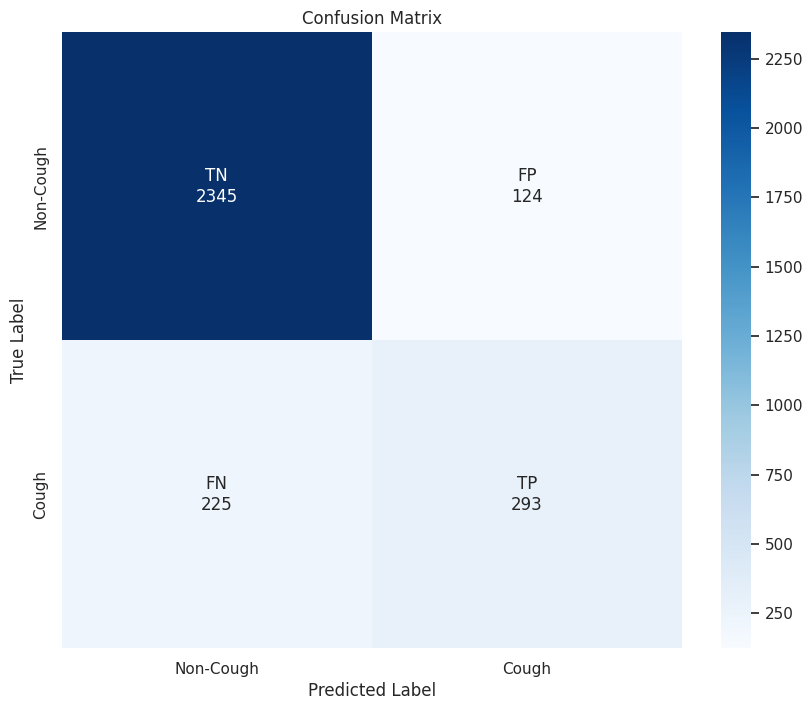

Final Results saved to RandomForest_ZCR_Test_Final_results.csv
                                     key  true_zeros  true_ones  pred_zeros  \
0   02aa80ef-a83b-477f-b01d-575651364b22         146         31         165   
1   1357788c-fd94-45ff-b31d-da0cda859731         147        152         220   
2   14a3c119-bee8-435a-9193-d2ce7cb84a03         136        121         190   
3   28d4e487-0d9d-4911-951d-5de7fcb5c986         163         96         192   
4   2e4d87d7-b9de-43c0-ae02-8bc985788b59         199          0         185   
5   3a85240c-0310-48c8-aef7-2337fbbbf168         310          0         265   
6   60dd67f9-5336-46aa-8c94-3bf1ee7a4629         310          0         290   
7   6a246f97-17c1-4206-92d1-9cc1f389d0ca         297          0         293   
8   6f3acced-953a-47aa-a001-b038d80262b2         126          0         126   
9   7d1428e9-7241-482b-8dbd-95f43a57c694         116         40         126   
10  88a9b00f-205e-4fbc-9cda-1793f2c7600b         215         78     

In [93]:
import pickle
import pandas as pd
import numpy as np
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score, roc_auc_score, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import joblib
from sklearn.impute import SimpleImputer

class RandomForest_Prediction:
    def __init__(self, model_path, test_data_path):
        self.model_path = model_path
        self.test_data_path = test_data_path
        self.model = None
        self.test_data = None
        self.X_test = None
        self.y_test = None
        self.y_pred = None
        self.y_pred_proba = None
        self.results_df = None

    def load_model(self):
        try:
            with open(self.model_path, 'rb') as file:
                self.model = pickle.load(file)
        except Exception as e:
            print(f"Standard pickle load failed: {e}")
            try:
                self.model = joblib.load(self.model_path)
            except Exception as e:
                print(f"joblib load failed: {e}")
                try:
                    with open(self.model_path, 'rb') as file:
                        self.model = pickle.load(file, encoding='latin1')
                except Exception as e:
                    print(f"pickle load with latin1 encoding failed: {e}")
                    raise Exception("Failed to load the model using multiple methods.")
        print("Model loaded successfully!")

    def load_test_data(self):
        try:
            self.test_data = pd.read_feather(self.test_data_path)
            print("Test data loaded successfully!")
        except Exception as e:
            print(f"Error loading the test data: {e}")
            print("Please check the test data file and its path.")
            exit(1)

    def preprocess_data(self):
        self.y_test = self.test_data['label']
        self.X_test = self.test_data.drop('label', axis=1)

        columns_to_remove = ['amp', 'key']
        self.X_test_removed = self.X_test[columns_to_remove].copy()
        self.X_test = self.X_test.drop(columns=columns_to_remove)

        print("Columns removed from prediction features:", columns_to_remove)

        model_features = self.model.feature_names_in_ if hasattr(self.model, 'feature_names_in_') else None

        if model_features is not None:
            self.X_test = self.X_test[model_features]
            print(f"Pruned features to match the {len(model_features)} features used in training.")
        else:
            print("Warning: Could not determine feature names from the model. Using all available features.")

        print("Features used for prediction:", self.X_test.columns.tolist())

        imputer = SimpleImputer(strategy='median')
        self.X_test_imputed = pd.DataFrame(imputer.fit_transform(self.X_test), columns=self.X_test.columns)

    def make_predictions(self):
        try:
            self.y_pred = self.model.predict(self.X_test_imputed)
            self.y_pred_proba = self.model.predict_proba(self.X_test_imputed)[:, 1]
            print("Predictions made successfully!")
        except Exception as e:
            print(f"Error making predictions: {e}")
            print("This might be due to a mismatch between the model's expected input and the preprocessed data.")
            print("Please check if the model was trained on the same features as in your test set.")
            exit(1)

    def create_results_df(self):
        self.results_df = pd.DataFrame({
            'key': self.X_test_removed['key'],
            'Cough (Yes (1)/No (0))': self.y_test,
            'Predicted_Cough': self.y_pred,
            'predicted_probability': self.y_pred_proba
        })
        self.results_df.to_csv('prediction_results.csv', index=False)
        print("Prediction results saved to 'prediction_results.csv'")

    def calculate_metrics(self):
        accuracy = accuracy_score(self.y_test, self.y_pred)
        recall = recall_score(self.y_test, self.y_pred)
        specificity = recall_score(self.y_test, self.y_pred, pos_label=0)
        precision = precision_score(self.y_test, self.y_pred)
        f1 = f1_score(self.y_test, self.y_pred)
        auc = roc_auc_score(self.y_test, self.y_pred_proba)

        print(f"\nMetrics:")
        print(f"Accuracy: {accuracy:.4f}")
        print(f"Recall: {recall:.4f}")
        print(f"Specificity: {specificity:.4f}")
        print(f"Precision: {precision:.4f}")
        print(f"F1-Score: {f1:.4f}")
        print(f"AUC: {auc:.4f}")

    def plot_confusion_matrix(self):
        cm = confusion_matrix(self.y_test, self.y_pred)
        TN, FP, FN, TP = cm.ravel()

        labels = np.array([[f'TN\n{TN}', f'FP\n{FP}'],
                           [f'FN\n{FN}', f'TP\n{TP}']])

        plt.figure(figsize=(10, 8))
        sns.heatmap(cm, annot=labels, fmt='', cmap='Blues',
                    xticklabels=['Non-Cough', 'Cough'], yticklabels=['Non-Cough', 'Cough'])
        plt.title('Confusion Matrix')
        plt.ylabel('True Label')
        plt.xlabel('Predicted Label')
        plt.savefig('confusion_matrix_labeled_with_counts.png')
        plt.show()

    @staticmethod
    def count_zeros_and_ones(list_of_values):
        arr = np.array(list_of_values)
        return np.bincount(arr, minlength=2)

    def aggregate_predictions(self):
        aggregated_df = self.results_df.groupby('key').agg(
            true_labels=('Cough (Yes (1)/No (0))', list),
            predicted_labels=('Predicted_Cough', list)
        ).reset_index()
        aggregated_df[['true_zeros', 'true_ones']] = aggregated_df['true_labels'].apply(self.count_zeros_and_ones).tolist()
        aggregated_df[['pred_zeros', 'pred_ones']] = aggregated_df['predicted_labels'].apply(self.count_zeros_and_ones).tolist()
        aggregated_df.drop(['true_labels', 'predicted_labels'], axis=1, inplace=True)
        return aggregated_df

    def calculate_confusion_matrix(self, aggregated_df):
        aggregated_df['TP'] = np.minimum(aggregated_df['true_ones'], aggregated_df['pred_ones'])
        aggregated_df['FP'] = np.maximum(0, aggregated_df['pred_ones'] - aggregated_df['true_ones'])
        aggregated_df['TN'] = np.minimum(aggregated_df['true_zeros'], aggregated_df['pred_zeros'])
        aggregated_df['FN'] = np.maximum(0, aggregated_df['true_ones'] - aggregated_df['pred_ones'])
        return aggregated_df

    def label_files_based_on_accuracy(self, aggregated_df):
        total_coughs = aggregated_df['TP'] + aggregated_df['FN']
        aggregated_df['accuracy'] = np.where(total_coughs > 0, aggregated_df['TP'] / total_coughs, 0)
        aggregated_df['label'] = (aggregated_df['accuracy'] >= 0.20).astype(int)
        return aggregated_df[['key', 'label']]

    def process_and_evaluate(self, csv_path):
        self.load_model()
        self.load_test_data()
        self.preprocess_data()
        self.make_predictions()
        self.create_results_df()
        self.calculate_metrics()
        self.plot_confusion_matrix()

        aggregated_df = self.aggregate_predictions()
        final_df = self.calculate_confusion_matrix(aggregated_df)
        labeled_files_df = self.label_files_based_on_accuracy(final_df)

        csv_df = pd.read_csv(csv_path)
        csv_df = csv_df[['uuid', 'Cough (Yes (1)/No (0))']].rename(columns={'Cough (Yes (1)/No (0))': 'y_truth'})

        merged_df = final_df.merge(csv_df, left_on='key', right_on='uuid', how='left')
        merged_df.drop(columns=['uuid'], inplace=True)
        merged_df['y_truth'] = merged_df['y_truth'].astype(int)

        correct_predictions = (merged_df['label'] == merged_df['y_truth']).sum()
        total_predictions = len(merged_df)


        merged_df.to_csv(f'{GDRIVE_DATA_DIR}/RandomForest_ZCR_Test_Final_results.csv', index=False)
        print('Final Results saved to RandomForest_ZCR_Test_Final_results.csv')


        return merged_df, percentage_correct

# Example usage
if __name__ == "__main__":
    model_path = (f'{GDRIVE_Model_DIR}/RandomForest_ZCR_Cough-Detection_Fold-3_1000trees.pkl')
    test_data_path = (f'{GDRIVE_DATA_DIR}/FE_ZCR_17_Testing.feather')
    csv_path = (f'{GDRIVE_DATA_DIR}/Dataset workflow.csv')

    rf_prediction = RandomForest_Prediction(model_path, test_data_path)
    final_results, accuracy = rf_prediction.process_and_evaluate(csv_path)
    print(final_results)
    print(f"\nFinal Accuracy: {accuracy:.2f}%")